In [1]:
import xsimlab as xs
import xarray as xr
import numpy as np
from pprint import pprint as pp

In [2]:
@xs.process
class Coords:
    ag = xs.variable(intent='out')
    rg = xs.variable(intent='out')
    counts = xs.foreign(Compute, 'counts', intent='out')
    
    def initialize(self):
        self.ag = 1
        self.rg = 2

@xs.process
class Compute:
    # ag = xs.foreign(Coords, 'ag', intent='in')
    counts = xs.variable(intent='in')
    
    # out_var = xs.variable(dims='ag', intent='out')
    
@xs.process
class DiffCoords(Coords):
    # ag = xs.variable(intent='out')
    # rg = xs.variable(intent='out')
    vert = xs.variable(intent='out')
    
    def run_step(self):
        self.ag += 1
        self.rg += 1
    
@xs.process
class DiffCompute(Compute):
    vert = xs.foreign(DiffCoords, 'vert', intent='in')
    rg = xs.foreign(Coords, 'rg', intent='in')
    # rg = xs.foreign(Coords, 'rg', intent='in')
    # out_var = xs.variable(dims='ag', intent='out')
    
model = xs.Model(dict(
    coords=Coords,
    compute=Compute
))

in_ds = xs.create_setup(
    model=model,
    clocks=dict(step=range(10)),
    input_vars=dict(),
    output_vars=dict(coords__ag='step')
)
in_ds.xsimlab.run(decoding=dict(mask_and_scale=False), model=model)

NameError: name 'Compute' is not defined

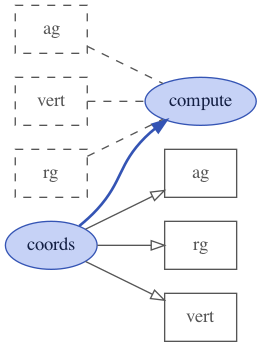

In [16]:
model.visualize(show_variables=True)

# Spec Sandbox

Speccing out high-level workflow defined below.

In [3]:
@xs.process
class ApplyCountsDelta:
    COUNTS_DIMS = ('age_group', 'risk_group')
    counts = xs.variable(
        dims=COUNTS_DIMS,
        static=False,
        intent='inout'
    )
    counts_delta = xs.group('counts_delta')
    
    def finalize_step(self):
        self.counts += xr.concat(self.counts_delta, dim='_delta').sum(dim='_delta')

In [4]:
@xs.process
class SomeEngine:
    counts = xs.foreign(ApplyCountsDelta, 'counts', intent='in')
    delta = xs.variable(groups=['counts_delta'], intent='out')
    
    def initialize(self):
        self.delta = xr.ones_like(self.counts)

In [5]:
@xs.process
class DefaultRiskCoords:
    risk_coords = xs.variable(groups=['counts_coords'], intent='out')
    
    def initialize(self):
        self.risk_coords = range(2)

In [6]:
@xs.process
class DefaultAgeCoords:
    age_coords = xs.variable(groups=['counts_coords'], intent='out')
    
    def initialize(self):
        self.age_coords = range(5)

In [7]:
@xs.process
class InitCounts:
    counts = xs.foreign(ApplyCountsDelta, 'counts', intent='out')
    # counts_info = xs.filter_variables(ApplyCountsDelta)
    # apply_info = xs.process_info(ApplyCountsDelta)
    # counts_info = xs.variable_info(ApplyCountsDelta, 'counts', buf=None)
    counts_coords = xs.group('counts_coords')
    
    def initialize(self):
        self.counts_dims = self._get_counts_dims()
        coords = self._get_da_coords_static()
        # print(self.counts_dims, coords)
        # assert 0
        self.counts = xr.DataArray(data=0., dims=self.counts_dims,
                                   coords=coords)
    
    def _get_counts_dims(self):
        # return xs.filter_variables(ApplyCountsDelta)['counts'].metadata['dims'][0]
        print(xs.utils.variables_dict(ApplyCountsDelta)['counts'])
        return xs.utils.variables_dict(ApplyCountsDelta)['counts'].metadata['dims'][0]
    
    def _get_da_coords_static(self):
        # return dict(age_group=range(5), risk_group=range(2))
        return [('age_group', range(5)), ('risk_group', range(2))]
    
    def _get_da_coords(self):
        coords = list()
        print(self.counts_coords.__name__)
        pp(xs.filter_variables(self))
        for coord in self.counts_coords:
            # coords.append(self.counts_coords[dim])
            # coords.extend(dim)
            print(coord)
        
        return tuple(coords)

In [8]:
model = xs.Model(dict(
    age_coords=DefaultAgeCoords,
    risk_coords=DefaultRiskCoords,
    apply=ApplyCountsDelta,
    engine=SomeEngine,
    init_counts=InitCounts
))

in_ds = xs.create_setup(
    model=model,
    clocks=dict(step=range(10)),
    input_vars=dict(),
    output_vars=dict(apply__counts='step')
)
in_ds.xsimlab.run(decoding=dict(mask_and_scale=False), model=model)

Attribute(name='counts', default=NOTHING, validator=None, repr=True, eq=True, order=True, hash=None, init=True, metadata=mappingproxy({'var_type': <VarType.VARIABLE: 'variable'>, 'dims': (('age_group', 'risk_group'),), 'intent': <VarIntent.INOUT: 'inout'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}}), type=None, converter=None, kw_only=True)


<xarray.Dataset>
Dimensions:        (age_group: 5, risk_group: 2, step: 10)
Coordinates:
  * step           (step) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: age_group, risk_group
Data variables:
    apply__counts  (step, age_group, risk_group) float64 0.0 0.0 0.0 ... 9.0 9.0

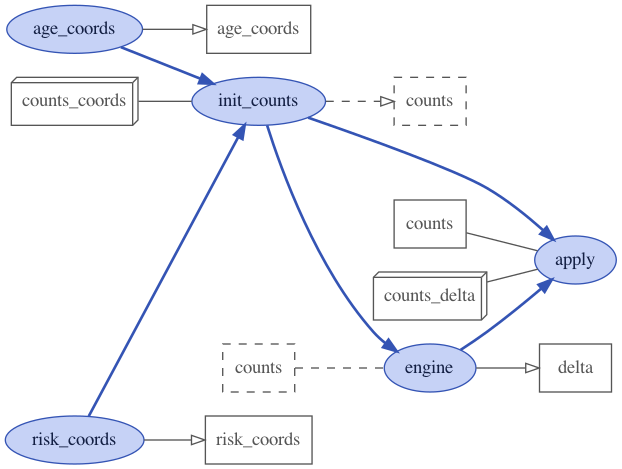

In [241]:
model.visualize(show_variables=True)

In [10]:
import xsimlab as xs
import xarray as xr

@xs.process
class CoordsX:
    x = xs.index(groups=['coords'], dims='x')
    
    def initialize(self):
        self.x = range(3)

@xs.process
class CoordsY:
    y = xs.index(groups=['coords'], dims='y')
    
    def initialize(self):
        self.y = range(5)
        
@xs.process
class InitArray:
    DIMS = ('x', 'y')
    
    arr = xs.variable(dims=('y', 'x'), intent='out')
    # coords = xs.group('coords')
    coords = dict(x=range(3), y=range(5))
    
    def initialize(self):
        self.arr = xr.DataArray(
            data=0.,
            dims=self.DIMS,
            coords={k: self.coords[k] for k in self.DIMS}
        )
        print(self.arr.attrs)
        
model = xs.Model(dict(
    coords_x=CoordsX,
    coords_y=CoordsY,
    init=InitArray
))

in_ds = xs.create_setup(
    model=model,
    clocks=dict(step=range(10)),
    input_vars=dict(),
    output_vars=dict()
)
in_ds.xsimlab.run(decoding=dict(mask_and_scale=False), model=model)

{}


<xarray.Dataset>
Dimensions:  (step: 10, x: 3, y: 5)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 9
  * x        (x) int64 0 1 2
  * y        (y) int64 0 1 2 3 4
Data variables:
    *empty*